# CNN for prediction task

Problem

The calorimeter has a single shower where the energy is distributed through multiple blocks. The shower center can be anywhere in the calorimeter ( –1000 < x,y < +1000 ) and will never be outside of that. Energy from the shower that falls outside of the calorimeter however, is lost. The solution to this problem will be three values: shower amplitude, x-coordinate of shower center and y-coordinate of shower center

The showers here are all “clean” with no noise or backgrounds. 

The data comes as PNG files (8-bit greyscale) for each of the events that are stored in the relevant directory such as "train_images". For this set, there is an CSV file named "train_images.csv". The first column is just the PNG file name and the last 3 columns are the labels: (amp, X, Y). 

The problem involves a 30x30 block imaginary calorimeter as shown in the diagram below. 
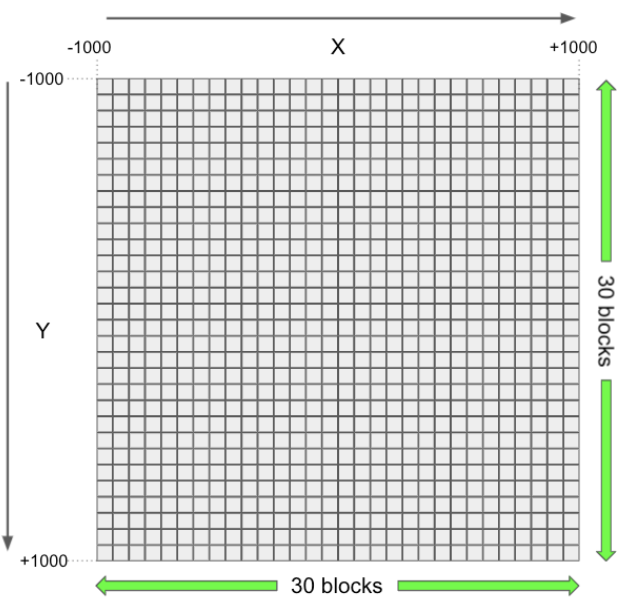


The problem has 3 data sets: train, test, judge

The train and test sets are the same in that they contain both features and labels. The Judge data has only features and no labels. The solutions to the problem will be the response of the AI/ML solution to this data. 

Here is an example image showing a single shower. 

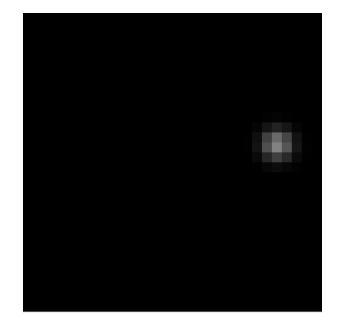

For this image, the shower (or cluster) is centered at (702.6, -119.0) and has an amplitude of 4.24 (in arbitrary units). The image is 30x30 pixels with values representing the energy deposition for each block. For the image, the values are scaled such that the largest possible energy deposition that could happen in a block is 255.

The solution to this problem should consist of a CSV file with columns representing the amplitude, x, y of the shower (in that order) in the same units as are used for the labels. These should correspond to the events in the judge data set, in the same order of the events there. 

My first idea was to built a multi-output Deep Learning model because we have 3 outputs: amplitude, x and y coordinates. But due to lack of experience I decided to build 3 single output models first.

Convolutional Neural Networks show good result with images. Our input is represented as a set of images, that's why I choose CNN  as a model. And we need to get the predictions for continuos values, so we face with regression task.

Firstly let's import all necessary python libraries

In [3]:
import os
from os import listdir
from os.path import isfile, join
import glob
import time
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Create function for nicely formatted time string

In [4]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

Get input from csv-file and create a Pandas DataFrame

In [5]:
source = "https://userweb.jlab.org/~tbritton/Hackathon2021_DataSets/Problem1/"

df_train_first = pd.read_csv(
    os.path.join(source,"train_images.csv"),usecols=[0,1,2,3], 
    na_values=['NA', '?'], header=None)


mapping = {df_train_first.columns[0]: 'filename', df_train_first.columns[1]: 'amplitude',
           df_train_first.columns[2]: 'coordinate_X', df_train_first.columns[3]: 'coordinate_Y' }
df_train_first = df_train_first.rename(columns=mapping)

df_train_first['filename'] = df_train_first['filename'].str.replace(r'^t\w*([^.])', '',regex=True)
df_train_first['filename'] = df_train_first['filename'].str.replace(r'.png', '',regex=True)+'.png'

df_train_first

,filename,amplitude,coordinate_X,coordinate_Y
0,event000000.png,4.2439,702.5571,-118.9555
1,event000001.png,2.7615,-67.0084,747.8185
2,event000002.png,3.1620,-831.5248,691.4152
3,event000003.png,2.3286,43.7651,-228.6005
4,event000004.png,5.0562,-111.0036,-602.6505
...,...,...,...,...
9995,event009995.png,3.5621,459.4613,740.6949
9996,event009996.png,4.9404,567.1249,482.7291
9997,event009997.png,2.0894,278.2298,-200.3925
9998,event009998.png,1.6943,140.1465,65.0474


We have 10 000 images in the train dataset. Let's divide them to the train (90%) and validation (10%) datasets 

In [6]:
train_pct = 0.9
train_cut = int(len(df_train_first) * train_pct)

df_train = df_train_first[0:train_cut]
df_validate = df_train_first[train_cut:]

print(f"Training size: {len(df_train)}")
print(f"Validate size: {len(df_validate)}")

Training size: 9000
Validate size: 1000


We are now ready to create two ImageDataGenerator objects. This technique can produce considerably stronger neural networks. The generator below flips the images both vertically and horizontally. Keras will train the neuron network both on the original images and the flipped images. This augmentation increases the size of the training data considerably.

The function flow_from_dataframe loads the labels from a Pandas dataframe connected to our train_images.csv file. 

In [7]:
def data_gen(source, df_train, df_validate, y_col):

    training_datagen = ImageDataGenerator(
      #horizontal_flip=True,
      #vertical_flip=True,
      fill_mode='nearest')

    train_generator = training_datagen.flow_from_dataframe(
            dataframe=df_train,
            directory=source,
            x_col="filename",
            y_col=y_col,
            target_size=(30, 30),
            color_mode='grayscale',
            batch_size=32,
            class_mode='other')

    validation_datagen = ImageDataGenerator()

    val_generator = validation_datagen.flow_from_dataframe(
            dataframe=df_validate,
            directory=source,
            x_col="filename",
            y_col=y_col,
            target_size=(30, 30),
            color_mode='grayscale',
            class_mode='other')
    
    return train_generator, val_generator

In [8]:
#path to the folder with images
path = "C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem1/train_images/"

#call function to create the data generator for the first output - amplitude
train_generator_amp, val_generator_amp = data_gen(path, df_train, df_validate,"amplitude")

#call function to create the data generator for the second output - coordinate_X
train_generator_X, val_generator_X = data_gen(path, df_train, df_validate,"coordinate_X")

#call function to create the data generator for the third output - coordinate_Y
train_generator_Y, val_generator_Y = data_gen(path, df_train, df_validate,"coordinate_Y")

Found 9000 validated image filenames.
Found 1000 validated image filenames.
Found 9000 validated image filenames.
Found 1000 validated image filenames.
Found 9000 validated image filenames.
Found 1000 validated image filenames.


Now we can build the model

In [10]:
def build_model(train_gen, val_gen):
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 30x30 
        # with grayscale.
        # This is the first convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', 
            input_shape=(30, 30, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])


    model.summary()
    epoch_steps = 250 
    validation_steps = len(df_validate)
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
            patience=5, verbose=1, mode='auto',
            restore_best_weights=True)

    start_time = time.time()
    history = model.fit(train_gen,  
      verbose = 1, 
      validation_data=val_gen, callbacks=[monitor], epochs=25)
    
   

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))
    
    return model

Let's build the model for each of the three outputs

In [15]:
# for amplitude
amp_model = build_model(train_generator_amp, val_generator_amp)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1180160   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [14]:
# for coordinate X
X_model = build_model(train_generator_X, val_generator_X)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1180160   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [11]:
# for coordinate Y
Y_model = build_model(train_generator_Y, val_generator_Y)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1180160   
____

Let's score our model

Scoring/predicting from a generator is a bit different than training. We do not want augmented images, and we do not wish to have the dataset shuffled. For scoring, we want a prediction for each input. We construct the generator as follows:
shuffle=False
batch_size=1
class_mode=None

In [12]:
#path to the folder with judge images
judge_path = "C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem1/judge_images"

judge_files = [f for f in listdir(judge_path) if isfile(join(judge_path, f))]

df_judge = pd.DataFrame(judge_files,columns=['filename'])

df_judge['filename'] = df_judge['filename'].str.replace(r'^t\w*([^.])', '',regex=True)
df_judge['filename'] = df_judge['filename'].str.replace(r'.png', '',regex=True)+'.png'

judge_datagen = ImageDataGenerator()

judge_generator = judge_datagen.flow_from_dataframe(
        dataframe=df_judge,
        directory=judge_path+'/',
        x_col="filename",
        batch_size=1,
        shuffle=False,
        target_size=(30, 30),
        color_mode='grayscale',
        class_mode=None)

Found 2000 validated image filenames.


We need to reset the generator to ensure we are always at the beginning.

In [17]:
#predict the first output
judge_generator.reset()
pred_amplitude = amp_model.predict(judge_generator,steps=len(df_judge))

In [20]:
#predict the second output
judge_generator.reset()
pred_X = X_model.predict(judge_generator,steps=len(df_judge))

In [25]:
#predict the third output
judge_generator.reset()
pred_Y = Y_model.predict(judge_generator,steps=len(df_judge))
pred_Y.shape

(2000, 1)

We can now create a DataFrame with predictions

In [21]:
output_judge = pd.DataFrame({'filename':df_judge['filename'],'amplitude':pred_amplitude.flatten(),
                      'X':pred_X.flatten(),'Y':pred_Y.flatten()})
output_judge

,filename,amplitude,X,Y
0,event000000.png,3.463574,290.717529,-80.917343
1,event000001.png,0.754641,200.684326,-824.740295
2,event000002.png,2.097583,-37.159042,27.901640
3,event000003.png,1.928637,563.199585,-185.385925
4,event000004.png,3.611503,-274.237915,-360.271667
...,...,...,...,...
1995,event001995.png,1.580876,-949.281250,387.266571
1996,event001996.png,5.090881,324.290741,-241.754517
1997,event001997.png,0.917639,275.864624,-29.428423
1998,event001998.png,4.723613,-447.534515,130.733276


And save the DataFrame as csv-file

In [22]:
path = "C:/Users/matsiuk/Documents/Python Scripts/DATA/Problem1"
output_judge.to_csv(os.path.join(path,"output_judge_Pr1_3_separate_datagens.csv"),index=False,header=False)